In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import exp
import scipy.optimize as optim

In [2]:
cases_ttl_data = pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv', parse_dates=True, squeeze=True)
#india_daily_cases = cases_ts_data[[ 'Daily Confirmed']]

In [3]:
def logistic_growth(t,a,b,c):
  return c/(1 + a * np.exp(-b*t) )

In [4]:
p0 = np.random.exponential(size = 3)
bounds = [0,[1000., 3.,  1378001292.]]

In [5]:
x = np.arange(len(cases_ttl_data['Total Confirmed'])) 
y = np.array(cases_ttl_data['Total Confirmed'])
(a,b,c), cov = optim.curve_fit(logistic_growth, x, y, bounds = bounds, p0 = p0)

In [6]:
print(a,b,c)

999.9999999299448 0.060051847131263984 207362.29768305374


In [7]:
#Peak occurs on which day??
t_fastest = np.log(a) / b
t_fastest

115.02985518185318

Text(0.5, 1.0, 'Model prediction for next 200 days In India')

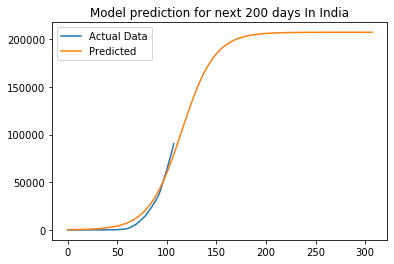

In [8]:
#Predicting the future 90 days
x_test = np.arange(len(cases_ttl_data['Total Confirmed']) + 200 )
def my_logistic(t):
  return c/(1 + a * np.exp(-b*t) )
y_pred = my_logistic(x_test)
cases_ttl_data['Total Confirmed'].plot()
plt.plot(x_test, y_pred)   #predicted
plt.legend(['Actual Data','Predicted'])
plt.title("Model prediction for next 200 days In India")


In [9]:
#What is the peak cases per day
print(y_pred[115] - y_pred[114])

3112.1007947310136


Text(0.5, 1.0, 'Model prediction for next 200 days In India')

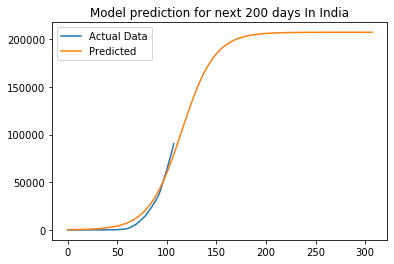

In [11]:
x = np.arange(len(cases_ttl_data['Total Confirmed']) + 200 )
y = my_logistic(x)
cases_ttl_data['Total Confirmed'].plot()
plt.plot(x, y)   #predicted
plt.legend(['Actual Data','Predicted'])
plt.title("Model prediction for next 200 days In India")


In [12]:
#Applying SIR model with 2L people as suseptable as total cases per logistic model is around 2L
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

class Learner(object):
    def __init__(self, loss, start_date='1/31/20', predict_range=200,s_0=200000, i_0=3, r_0=20):
        self.loss = loss
        self.start_date = start_date
        self.predict_range = predict_range
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
    

    def extend_index(self, index, new_size):
        values = list()
        current = datetime.strptime(self.start_date, '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data, recovered, death, s_0, i_0, r_0):
        new_index = self.extend_index(data.index, self.predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_actual, extended_recovered, extended_death, solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))


    def train(self):
        dframe=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')
        recovered=dframe['Total Recovered']
        death=dframe['Total Deceased']
        data=dframe['Total Confirmed']-recovered-death
        optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        beta, gamma = optimal.x
        new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death,  self.s_0, self.i_0, self.r_0)
        df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title("INDIA"+" "+"COVID19 behaviour assuming a total of 2L cases")
        df.plot(ax=ax)
        print(f"country= INDIA, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
        fig.savefig("India.png")


def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

      fun: 488.1257302411342
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.13071355e+10, 6.71871034e+04])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 369
      nit: 10
   status: 2
  success: False
        x: array([6.85608681e-07, 3.66125365e-02])
country= INDIA, beta=0.00000069, gamma=0.03661254, r_0:0.00001873


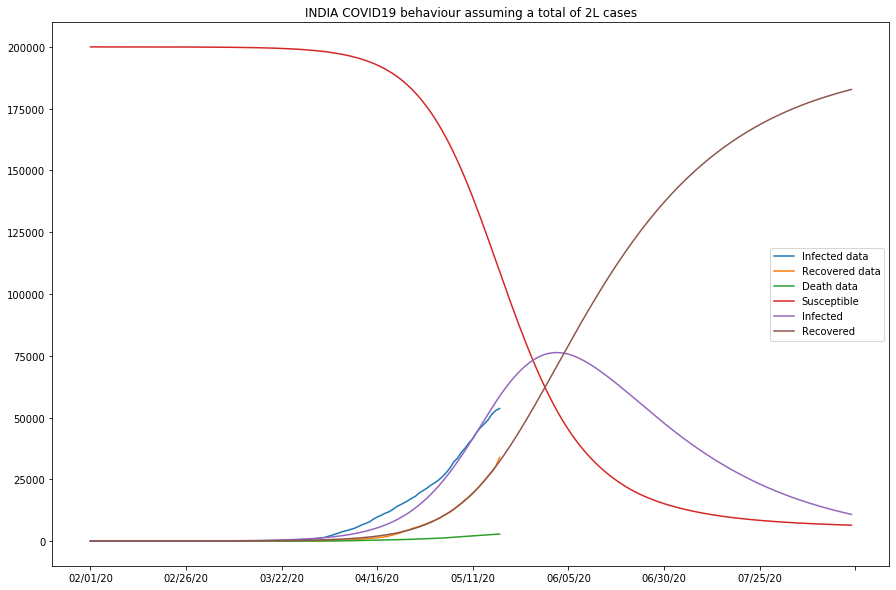

In [13]:
india_learner=Learner(loss=loss)
india_learner.train()